In [46]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [47]:
#change the tickers here according to what's in the portfolio
tickers = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [48]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ETR     1259 non-null   float64
 1   AMD     1259 non-null   float64
 2   EPAM    1259 non-null   float64
 3   ASML    1259 non-null   float64
 4   AUDC    1259 non-null   float64
 5   DSGX    1259 non-null   float64
 6   MGIC    1259 non-null   float64
 7   RDWR    1259 non-null   float64
 8   IDXX    1259 non-null   float64
 9   IQV     1259 non-null   float64
 10  BDSI    1259 non-null   float64
 11  ICLR    1259 non-null   float64
 12  MEDP    1259 non-null   float64
 13  MODV    1259 non-null   float64
 14  RGEN    1259 non-null   float64
 15  TROW    1259 non-null   float64
 16  CG      1259 non-null   float64
 17  CSWC    1259 non-null   float64
 18  TBBK    1259 non-null   float64
 19  CBRE    1259 non-null   float64
 20  SBAC    1259 non-null   float64
 21  ^FVX    1259 non-nu

## Function that saves dataframe to CSV

In [49]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [50]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [51]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [52]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [53]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [54]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [55]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [56]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [57]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [58]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC']

#add in the weightage of stocks
port_shares = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,0.644731,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,33.293530,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,0.661702,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,33.387581,0.002825
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,0.658678,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,33.360941,-0.000798
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
2017-01-09,3.466945,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,0.658005,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227233,33.456085,-0.003591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5.461537,1.887081,15.755003,23.018517,0.791210,1.583638,0.152285,0.049670,30.804386,0.329993,...,2.309908,11.915995,3.127916,0.871310,0.298796,0.273948,1.785198,16.783239,121.464094,0.006800
2020-12-28,5.479294,1.882765,15.635185,22.882720,0.793423,1.552337,0.151089,0.050566,30.653196,0.328830,...,2.345363,11.388060,3.123275,0.873533,0.307631,0.276392,1.786333,16.858299,120.604630,-0.007076
2020-12-29,5.541155,1.862622,15.552063,23.062355,0.764098,1.575415,0.155275,0.050511,30.614159,0.327911,...,2.259499,11.509844,3.130026,0.868532,0.310156,0.272726,1.761936,16.843043,120.715852,0.000922


## Get old data for portfolio

In [59]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,0.644731,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,33.293530,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,0.661702,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,33.387581,0.002825
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,0.658678,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,33.360941,-0.000798
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
2017-01-09,3.466945,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,0.658005,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227233,33.456085,-0.003591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5.461537,1.887081,15.755003,23.018517,0.791210,1.583638,0.152285,0.049670,30.804386,0.329993,...,2.309908,11.915995,3.127916,0.871310,0.298796,0.273948,1.785198,16.783239,121.464094,0.006800
2020-12-28,5.479294,1.882765,15.635185,22.882720,0.793423,1.552337,0.151089,0.050566,30.653196,0.328830,...,2.345363,11.388060,3.123275,0.873533,0.307631,0.276392,1.786333,16.858299,120.604630,-0.007076
2020-12-29,5.541155,1.862622,15.552063,23.062355,0.764098,1.575415,0.155275,0.050511,30.614159,0.327911,...,2.259499,11.509844,3.130026,0.868532,0.310156,0.272726,1.761936,16.843043,120.715852,0.000922


## Forecasting

In [60]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [61]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [62]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,0.644731,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,33.293530,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,0.661702,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,33.387581,0.002825
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,0.658678,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,33.360941,-0.000798
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
2017-01-07,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,5.461537,1.887081,15.755003,23.018517,0.791210,1.583638,0.152285,0.049670,30.804386,0.329993,...,2.309908,11.915995,3.127916,0.871310,0.298796,0.273948,1.785198,16.783239,121.464094,0.006800
2020-12-28,5.479294,1.882765,15.635185,22.882720,0.793423,1.552337,0.151089,0.050566,30.653196,0.328830,...,2.345363,11.388060,3.123275,0.873533,0.307631,0.276392,1.786333,16.858299,120.604630,-0.007076
2020-12-29,5.541155,1.862622,15.552063,23.062355,0.764098,1.575415,0.155275,0.050511,30.614159,0.327911,...,2.259499,11.509844,3.130026,0.868532,0.310156,0.272726,1.761936,16.843043,120.715852,0.000922


In [63]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [64]:
tot_port_df

,Total
Date,
2017-01-03,33.293530
2017-01-04,33.387581
2017-01-05,33.360941
2017-01-06,33.576649
2017-01-07,33.576649
...,...
2020-12-27,121.464094
2020-12-28,120.604630
2020-12-29,120.715852


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Observations : 1459


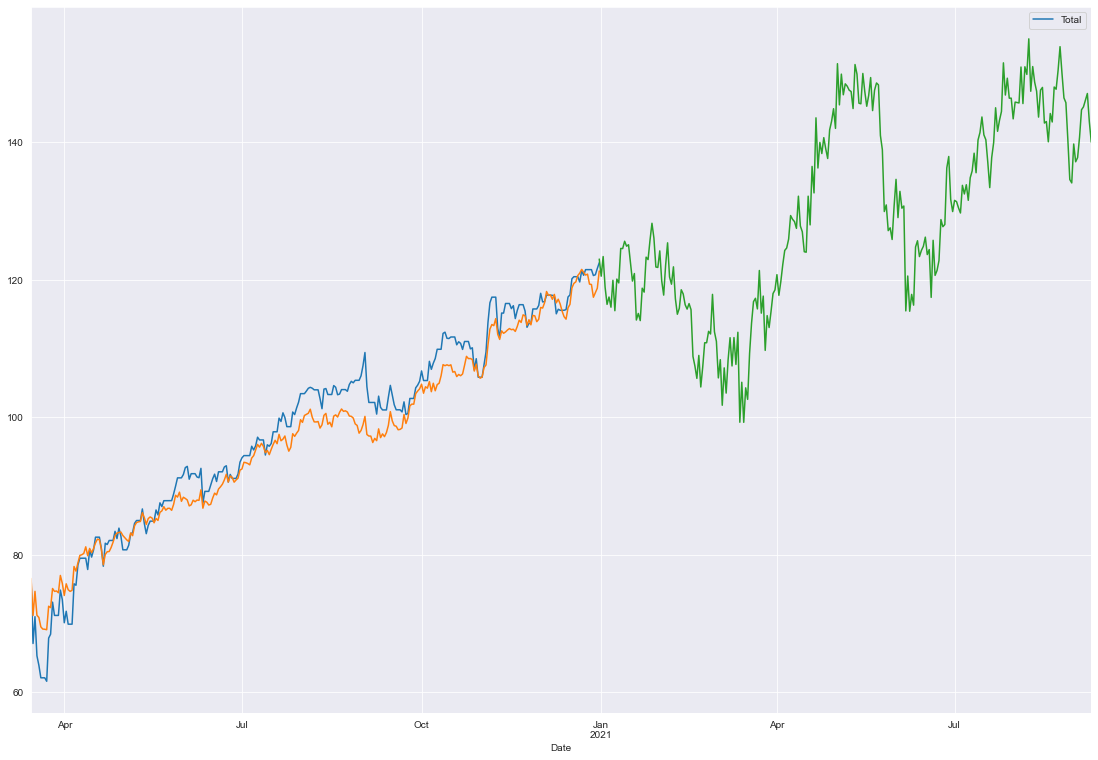

In [65]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [66]:
forecast

2020-12-31    122.996627
2021-01-01    120.510418
2021-01-02    123.363052
2021-01-03    118.903676
2021-01-04    116.414581
                 ...    
2021-09-05    145.124624
2021-09-06    146.085848
2021-09-07    147.068903
2021-09-08    142.980664
2021-09-09    139.991213
Freq: D, Length: 253, dtype: float64

In [67]:
forecast_df = pd.DataFrame(forecast)

In [68]:
forecast_df

,0
2020-12-31,122.996627
2021-01-01,120.510418
2021-01-02,123.363052
2021-01-03,118.903676
2021-01-04,116.414581
...,...
2021-09-05,145.124624
2021-09-06,146.085848
2021-09-07,147.068903
2021-09-08,142.980664


In [69]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [70]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.020214
2021-01-02,0.002979
2021-01-03,-0.033277
2021-01-04,-0.053514
...,...
2021-09-05,0.179907
2021-09-06,0.187722
2021-09-07,0.195715
2021-09-08,0.162476


In [71]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  13.817115


## Backtesting

In [72]:
tickers2 = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [73]:
panel_data2 = panel_data2['Adj Close']

In [74]:
panel_data2

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,ICLR,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,94.166412,92.290001,358.480011,487.229980,26.848873,58.139999,15.175845,27.559999,496.959991,177.520004,...,193.660004,137.860001,137.899994,189.139999,142.749695,30.581202,16.510559,13.570000,62.400002,271.858215
2020-12-31,95.311989,91.709999,358.350006,485.051971,26.616997,58.480000,15.098662,27.750000,499.869995,179.169998,...,194.979996,139.199997,138.630005,191.630005,144.477036,30.600668,16.862047,13.650000,62.720001,279.353729
2021-01-04,93.564987,92.300003,348.059998,497.264801,26.462420,57.730000,14.432972,27.280001,491.769989,176.600006,...,192.020004,134.419998,141.360001,190.660004,140.945984,30.279480,16.938046,13.550000,59.500000,272.917694
2021-01-05,92.314400,92.769997,345.700012,502.595459,27.728056,58.820000,14.375086,27.350000,497.260010,179.339996,...,195.690002,133.990005,145.679993,194.669998,142.282059,30.600668,16.890547,13.620000,59.419998,269.897675
2021-01-06,93.775017,90.330002,329.660004,487.538300,27.728056,57.200001,14.124246,27.400000,483.600006,186.250000,...,205.479996,139.880005,155.580002,197.009995,144.610657,30.201614,16.748051,14.940000,60.610001,262.035828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,109.092499,146.139999,663.080017,801.409973,33.800323,80.900002,20.666519,38.340000,645.020020,278.010010,...,307.929993,223.369995,152.139999,264.649994,193.571014,55.196152,24.795002,24.820000,105.820000,373.462097
2021-12-27,109.825798,154.360001,697.000000,811.429993,34.402489,81.820000,21.160698,40.820000,654.840027,282.059998,...,307.619995,227.899994,151.100006,267.859985,197.565552,55.852657,24.579479,25.389999,107.790001,382.522247
2021-12-28,110.876190,153.149994,682.200012,804.770020,34.165573,82.000000,20.824657,40.430000,651.280029,280.609985,...,306.049988,218.300003,149.979996,253.770004,197.654755,55.176258,24.520700,25.049999,107.720001,383.889252


## Portfolio Analysis

In [75]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,ICLR,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.012165,-0.006285,-0.000363,-0.004470,-0.008636,0.005848,-0.005086,0.006894,0.005856,0.009295,...,0.006816,0.009720,0.005294,0.013165,0.012100,0.000637,0.021289,0.005895,0.005128,0.027571
2021-01-04,-0.018329,0.006433,-0.028715,0.025178,-0.005807,-0.012825,-0.044089,-0.016937,-0.016204,-0.014344,...,-0.015181,-0.034339,0.019693,-0.005062,-0.024440,-0.010496,0.004507,-0.007326,-0.051339,-0.023039
2021-01-05,-0.013366,0.005092,-0.006780,0.010720,0.047828,0.018881,-0.004011,0.002566,0.011164,0.015515,...,0.019113,-0.003199,0.030560,0.021032,0.009479,0.010607,-0.002804,0.005166,-0.001345,-0.011066
2021-01-06,0.015822,-0.026302,-0.046399,-0.029959,0.000000,-0.027542,-0.017450,0.001828,-0.027471,0.038530,...,0.050028,0.043958,0.067957,0.012020,0.016366,-0.013041,-0.008436,0.096916,0.020027,-0.029129
2021-01-07,-0.034511,0.053471,0.026755,0.022867,0.018467,0.024475,0.019126,0.015328,0.023966,0.009718,...,0.019321,0.000143,0.046150,0.035937,0.019930,0.014180,0.044243,0.017403,0.014684,0.002305


In [76]:
portfolio_weights = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,ICLR,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000730,-0.000129,-0.000016,-0.000214,-0.000247,0.000155,-0.000053,0.000013,0.000363,0.000017,...,0.000077,0.000142,0.000089,0.000802,0.000267,0.000018,0.000404,0.000120,0.000145,0.001699
2021-01-04,-0.001100,0.000132,-0.001270,0.001206,-0.000166,-0.000340,-0.000455,-0.000031,-0.001004,-0.000027,...,-0.000172,-0.000501,0.000331,-0.000308,-0.000540,-0.000300,0.000086,-0.000149,-0.001456,-0.001420
2021-01-05,-0.000802,0.000105,-0.000300,0.000514,0.001370,0.000501,-0.000041,0.000005,0.000692,0.000029,...,0.000217,-0.000047,0.000514,0.001281,0.000210,0.000303,-0.000053,0.000105,-0.000038,-0.000682
2021-01-06,0.000949,-0.000541,-0.002051,-0.001435,0.000000,-0.000731,-0.000180,0.000003,-0.001702,0.000072,...,0.000567,0.000641,0.001142,0.000732,0.000362,-0.000372,-0.000160,0.001974,0.000568,-0.001795
2021-01-07,-0.002071,0.001099,0.001183,0.001096,0.000529,0.000649,0.000198,0.000028,0.001485,0.000018,...,0.000219,0.000002,0.000775,0.002188,0.000441,0.000405,0.000840,0.000354,0.000417,0.000142


In [77]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31    0.004177
2021-01-04   -0.007216
2021-01-05    0.004318
2021-01-06   -0.001788
2021-01-07    0.011029
dtype: float64

Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,27.9%
Cumulative returns,27.9%
Annual volatility,10.6%
Sharpe ratio,2.38
Calmar ratio,5.09
Stability,0.93
Max drawdown,-5.5%


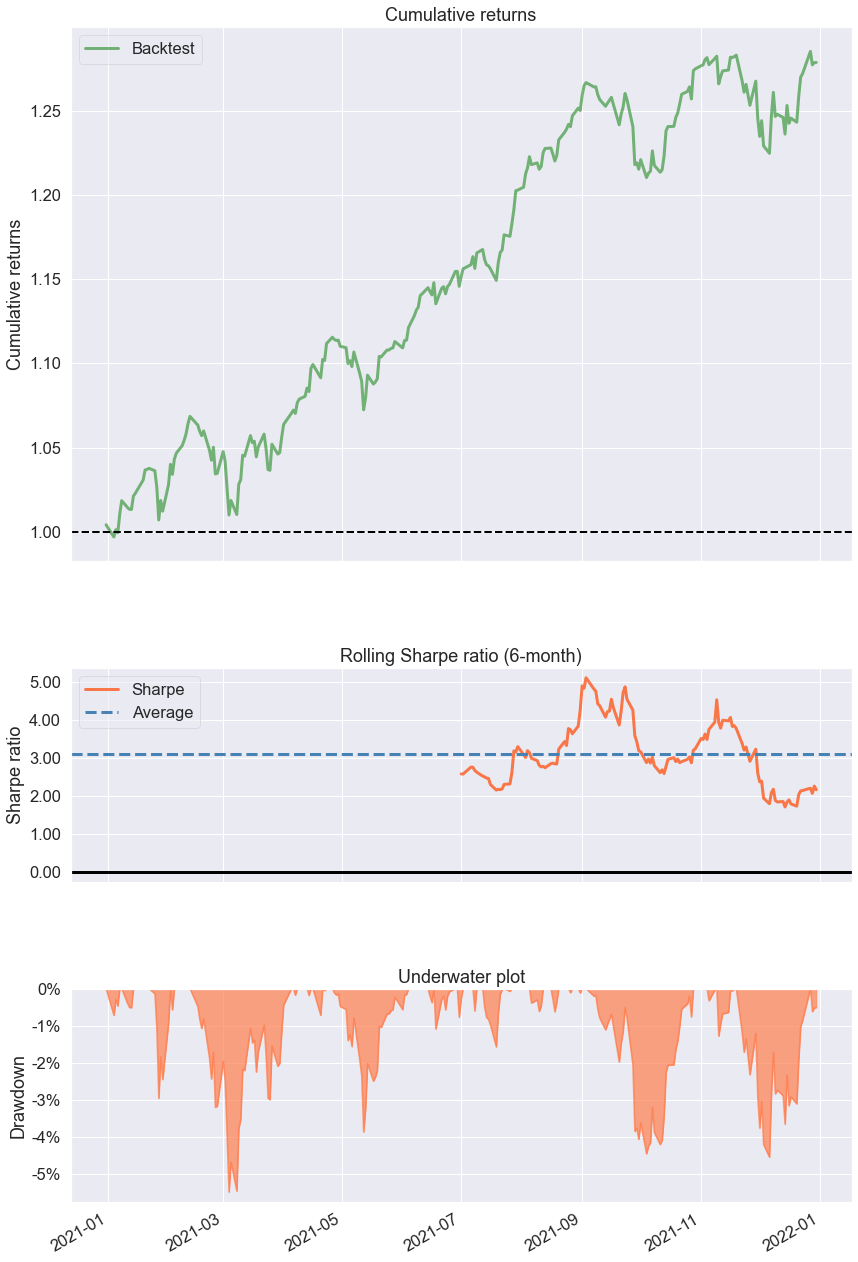

In [78]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [79]:
import itertools

In [80]:
weights = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632]

In [81]:
panel_data2 = panel_data2 * weights

In [82]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [83]:
#forecasted portfolio value
panel_data2

Symbols,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MEDP,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,5.649985,1.896947,15.849620,23.343481,0.768801,1.542257,0.156770,0.050402,30.793231,0.332957,...,2.010495,2.317134,11.517151,3.155339,0.872977,0.313402,0.276392,1.770163,16.755166,121.620624
2020-12-31,5.718719,1.885026,15.843872,23.239131,0.762162,1.551276,0.155972,0.050749,30.973544,0.336051,...,2.030037,2.329400,11.668773,3.193520,0.873533,0.320074,0.278022,1.779241,17.217129,122.468265
2021-01-04,5.613899,1.897153,15.388916,23.824255,0.757736,1.531381,0.149095,0.049890,30.471642,0.331231,...,1.960327,2.375272,11.609707,3.115470,0.864364,0.321516,0.275985,1.687896,16.820463,121.275823
2021-01-05,5.538864,1.906813,15.284573,24.079650,0.793976,1.560295,0.148498,0.050018,30.811821,0.336370,...,1.954057,2.447861,11.853884,3.145003,0.873533,0.320615,0.277411,1.685627,16.634333,121.976292
2021-01-06,5.626501,1.856661,14.575390,23.358252,0.793976,1.517322,0.145906,0.050109,29.965404,0.349330,...,2.039954,2.614211,11.996372,3.196474,0.862141,0.317910,0.304296,1.719384,16.149792,119.824162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,6.545550,3.003791,29.317022,38.396033,0.967852,2.146002,0.213489,0.070116,39.967504,0.521436,...,3.257539,2.556408,16.115120,4.278694,1.575640,0.470656,0.505531,3.001902,23.017216,179.457072
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,3.323602,2.538933,16.310584,4.366989,1.594381,0.466565,0.517141,3.057787,23.575611,183.285667
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,3.183600,2.520114,15.452614,4.368961,1.575072,0.465449,0.510216,3.055801,23.659862,181.142680


In [84]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [85]:
actual_portfolio_value

[121.62062433538141,
 122.46826513297003,
 121.27582284444549,
 121.97629206482047,
 119.82416165413485,
 122.18971870312187,
 124.39017045923568,
 123.31479233758594,
 122.5401531015933,
 122.90938660010775,
 124.54838715553412,
 124.56386631296284,
 126.15267910620918,
 127.52751587119077,
 128.44543022740172,
 128.19408103702497,
 127.60236934002742,
 125.03346599083869,
 120.69283265573574,
 123.96699548026875,
 122.68767767693109,
 126.42883801902924,
 128.9254406636657,
 126.48769177470163,
 128.29272468041984,
 129.21266791201717,
 129.65408404812266,
 130.36219720336362,
 131.2972037153226,
 133.78516184216966,
 135.50404375248704,
 134.21226140587407,
 132.9815847745528,
 132.83744725739479,
 132.84874167622604,
 130.25285472069513,
 128.73774580161924,
 130.70112056712256,
 127.10958024205627,
 127.90673409054854,
 130.7836879061734,
 128.8287344985091,
 124.07805437784548,
 119.35095169310331,
 121.85160941395739,
 118.37376417383422,
 122.8205552923476,
 122.2327764547045,


In [86]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [87]:
forecasted_portrfolio_value

[122.99662736259505,
 120.51041776541997,
 123.36305189586017,
 118.9036759937277,
 116.41458101404834,
 117.48245639950987,
 116.00173903845678,
 119.9121747055528,
 115.49061572264672,
 120.08914465872483,
 119.53243433253665,
 124.54443702172797,
 124.52488619575739,
 125.58946816422413,
 124.87017116574016,
 125.08386171330064,
 122.42572601468694,
 119.79885673483324,
 120.89561717739109,
 114.13856161137026,
 115.09465749086928,
 114.05372974925731,
 118.76536874399672,
 118.19450357527823,
 123.27731053265592,
 122.92500501235946,
 125.74453111146434,
 128.2046576298275,
 126.05440887307142,
 121.84608007798178,
 121.78057525156576,
 124.1903847952942,
 119.81562683389672,
 117.75960048046494,
 122.13588470830368,
 125.36078958985694,
 120.39863280609289,
 119.34592121947746,
 121.86991151990296,
 117.22598552209514,
 114.97743901579557,
 115.83386545003077,
 118.53518786963956,
 117.92455399910178,
 116.36319858245584,
 115.72679169382242,
 116.52890202537543,
 115.645508118950

## Calculate MAPE of forecasted period

In [88]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.15
MAPE % : 15.34 %



## Mean Squared Error

In [106]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print(sqrt(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value)))

29.449543722614024


## Forecast for future

In [90]:
#change to the list of stocks we using
port_list = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC']

#add in the weightage of stocks
port_shares = [0.06,0.0205542,0.0442134,0.0479106,0.0286344,0.0265266,0.0103302,0.0018288,0.0619632,
               0.0018756,0.0125514,0.011331,0.0145836,0.016803,0.0608922,0.022104,0.0285462,0.0189819,
               0.0203679,0.028368,0.061632]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,0.644731,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,33.293530,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,0.661702,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,33.387581,0.002825
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,0.658678,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,33.360941,-0.000798
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
2017-01-09,3.466945,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,0.658005,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227233,33.456085,-0.003591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,2.538933,16.310584,4.366989,1.594381,0.466565,0.517141,3.057787,23.575611,183.285667,0.021334
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,2.520114,15.452614,4.368961,1.575072,0.465449,0.510216,3.055801,23.659862,181.142680,-0.011692
2021-12-29,6.688245,3.047366,29.969612,38.423342,0.983964,2.186853,0.215531,0.075840,40.628651,0.529369,...,2.524147,15.704098,4.327990,1.543838,0.463032,0.519585,3.080197,23.673393,181.329045,0.001029


In [91]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,0.644731,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,33.293530,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,0.661702,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,33.387581,0.002825
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,0.658678,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,33.360941,-0.000798
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
2017-01-09,3.466945,0.236168,2.955223,5.133768,0.159743,0.562364,0.061087,0.026518,7.374860,0.146278,...,0.658005,1.969254,1.374627,0.373683,0.247803,0.144612,0.883096,6.227233,33.456085,-0.003591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,2.538933,16.310584,4.366989,1.594381,0.466565,0.517141,3.057787,23.575611,183.285667,0.021334
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,2.520114,15.452614,4.368961,1.575072,0.465449,0.510216,3.055801,23.659862,181.142680,-0.011692
2021-12-29,6.688245,3.047366,29.969612,38.423342,0.983964,2.186853,0.215531,0.075840,40.628651,0.529369,...,2.524147,15.704098,4.327990,1.543838,0.463032,0.519585,3.080197,23.673393,181.329045,0.001029


In [92]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [93]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [94]:
tot_port_df

,ETR,AMD,EPAM,ASML,AUDC,DSGX,MGIC,RDWR,IDXX,IQV,...,MODV,RGEN,TROW,CG,CSWC,TBBK,CBRE,SBAC,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,3.557167,0.234935,2.814625,5.040667,0.166831,0.563690,0.060648,0.026847,7.286872,0.144290,...,0.644731,1.896792,1.431439,0.349069,0.242171,0.164165,0.895578,6.380812,33.293530,NaN
2017-01-04,3.572774,0.234935,2.845574,5.016479,0.164806,0.568996,0.061087,0.026993,7.184633,0.144946,...,0.661702,1.966818,1.452767,0.359138,0.248099,0.154796,0.910045,6.389882,33.387581,0.002825
2017-01-05,3.560093,0.231029,2.862818,5.076721,0.159236,0.561038,0.061527,0.026865,7.185253,0.144421,...,0.658678,2.016141,1.441442,0.364732,0.247803,0.146242,0.902386,6.305231,33.360941,-0.000798
2017-01-06,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
2017-01-07,3.571798,0.232674,2.956550,5.071244,0.162274,0.563690,0.061087,0.026792,7.333964,0.145959,...,0.662878,2.015532,1.427287,0.372564,0.244542,0.146038,0.885082,6.259279,33.576649,0.006466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.589548,3.172746,30.816740,38.876098,0.985095,2.170406,0.218594,0.074652,40.575984,0.529032,...,2.538933,16.310584,4.366989,1.594381,0.466565,0.517141,3.057787,23.575611,183.285667,0.021334
2021-12-28,6.652571,3.147876,30.162382,38.557014,0.978311,2.175181,0.215123,0.073938,40.355395,0.526312,...,2.520114,15.452614,4.368961,1.575072,0.465449,0.510216,3.055801,23.659862,181.142680,-0.011692
2021-12-29,6.688245,3.047366,29.969612,38.423342,0.983964,2.186853,0.215531,0.075840,40.628651,0.529369,...,2.524147,15.704098,4.327990,1.543838,0.463032,0.519585,3.080197,23.673393,181.329045,0.001029


In [95]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['ETR','AMD','EPAM','ASML','AUDC','DSGX','MGIC','RDWR',
          'IDXX','IQV','BDSI','ICLR','MEDP','MODV','RGEN','TROW',
          'CG','CSWC','TBBK','CBRE','SBAC', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [96]:
tot_port_df

,Total
Date,
2017-01-03,33.293530
2017-01-04,33.387581
2017-01-05,33.360941
2017-01-06,33.576649
2017-01-07,33.576649
...,...
2021-12-27,183.285667
2021-12-28,181.142680
2021-12-29,181.329045


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


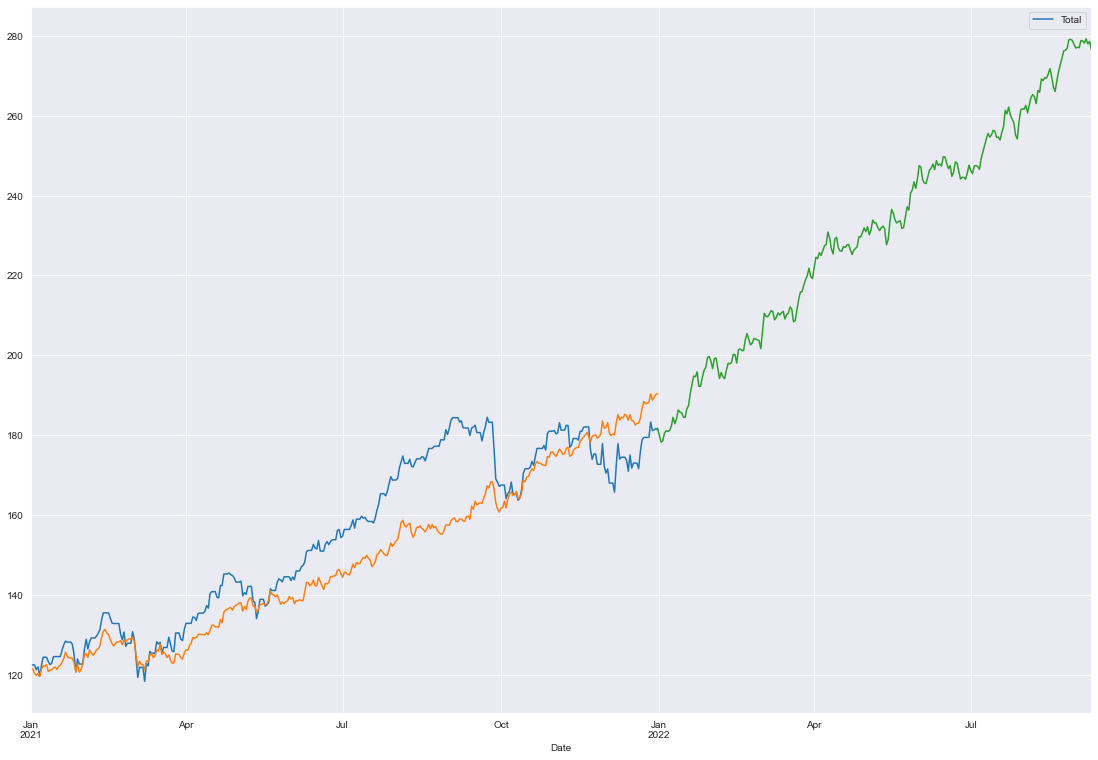

In [97]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [98]:
## Calculate annualized returns for forecasted

In [99]:
forecast

2021-12-31    181.749363
2022-01-01    180.082740
2022-01-02    178.282139
2022-01-03    178.530970
2022-01-04    180.491227
                 ...    
2022-09-05    278.196517
2022-09-06    279.258389
2022-09-07    278.002745
2022-09-08    278.596347
2022-09-09    276.686939
Freq: D, Length: 253, dtype: float64

In [100]:
forecast_df = pd.DataFrame(forecast)

In [101]:
forecast_df

,0
2021-12-31,181.749363
2022-01-01,180.082740
2022-01-02,178.282139
2022-01-03,178.530970
2022-01-04,180.491227
...,...
2022-09-05,278.196517
2022-09-06,279.258389
2022-09-07,278.002745
2022-09-08,278.596347


In [102]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [103]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.009170
2022-01-02,-0.019077
2022-01-03,-0.017708
2022-01-04,-0.006922
...,...
2022-09-05,0.530660
2022-09-06,0.536503
2022-09-07,0.529594
2022-09-08,0.532860


In [104]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2022-09-09  52.235438
